# Test on Velodyne data

In [5]:
%matplotlib widget
import numpy as np
import os
import time

from planeslam.general import plot_3D_setup, downsample
from planeslam.mesh import LidarMesh
from planeslam.scan import Scan
from planeslam.clustering import cluster_mesh_graph_search, mesh_cluster_pts
from planeslam.extraction import scan_from_clusters

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data

In [6]:
# Read in point cloud data
pcpath = os.path.join(os.getcwd(),'..', 'data', 'velodyne', '6_7_2022', 'durand_3rd_floor', 'run_1')

In [7]:
# PCs = []
# for i in range(len(os.listdir(pcpath))):
#     filename = pcpath+'/pc_'+str(i)+'.npy'
#     PC = np.load(filename)
#     PCs.append(PC)

frame = 1000
filename = pcpath+'/pc_'+str(frame)+'.npy'
PC = np.load(filename)

In [8]:
# Downsample
PC = downsample(PC, factor=5, axis=0)

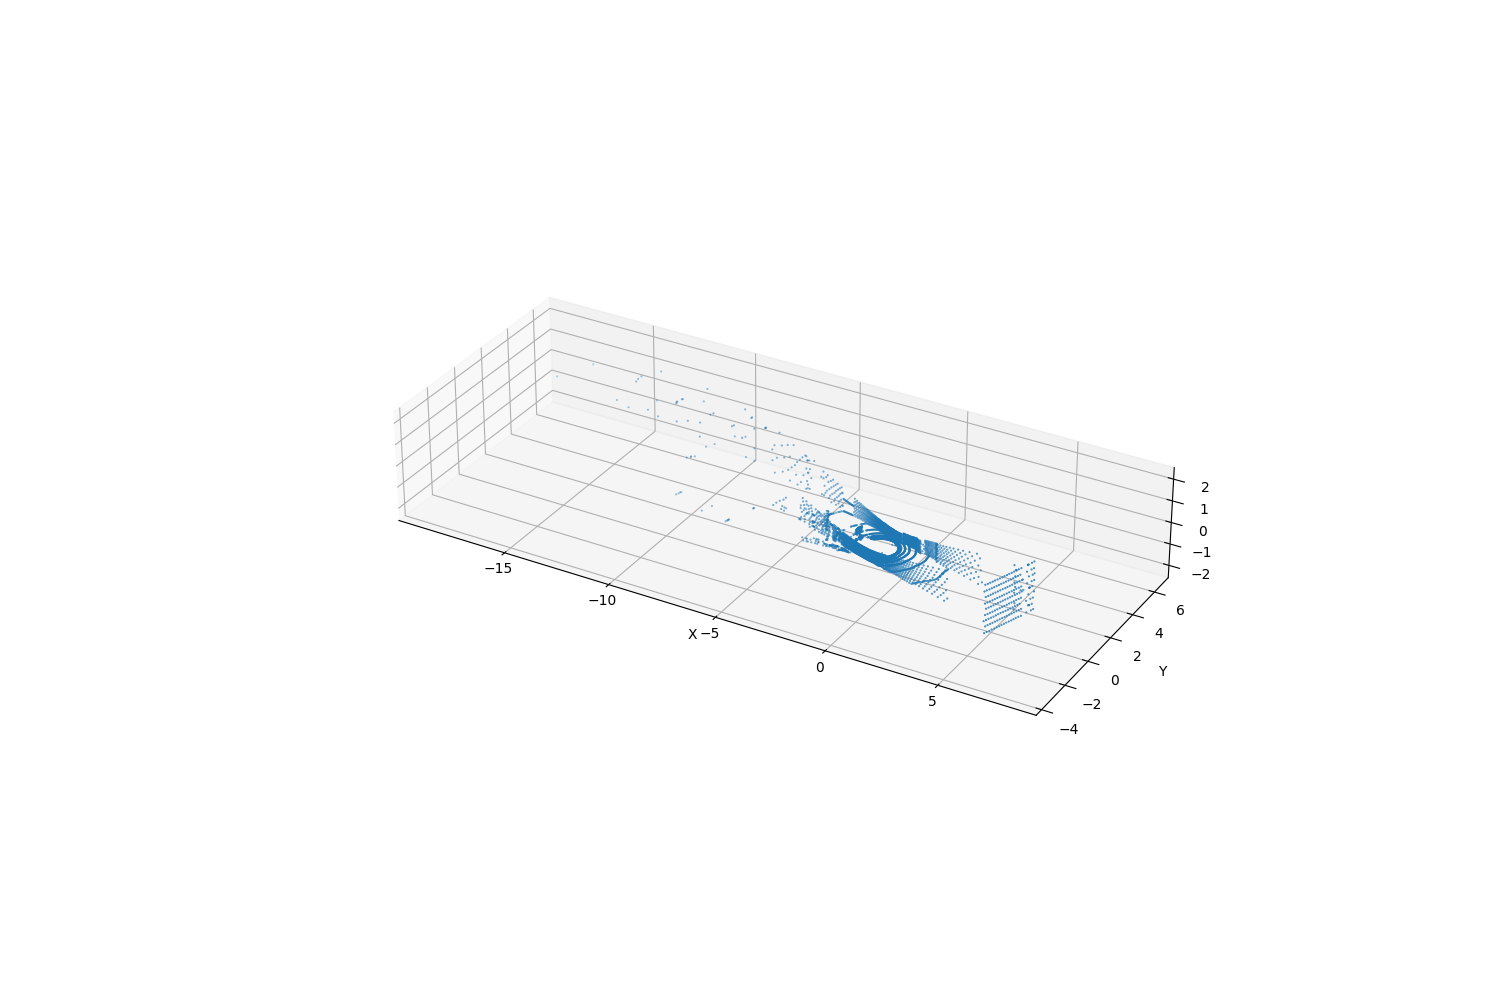

In [5]:
ax = plot_3D_setup(PC, figsize=(15,10))
ax.scatter3D(PC[:,0], PC[:,1], PC[:,2], marker='.', s=1)  

Cluster

In [6]:
# Create the mesh
mesh = LidarMesh(PC)
mesh.prune(edge_len_lim=1)
start_time = time.time()
# Cluster the mesh with graph search
clusters, avg_normals = cluster_mesh_graph_search(mesh)
print("elapsed time: ", time.time() - start_time)

elapsed time:  1.5774328708648682


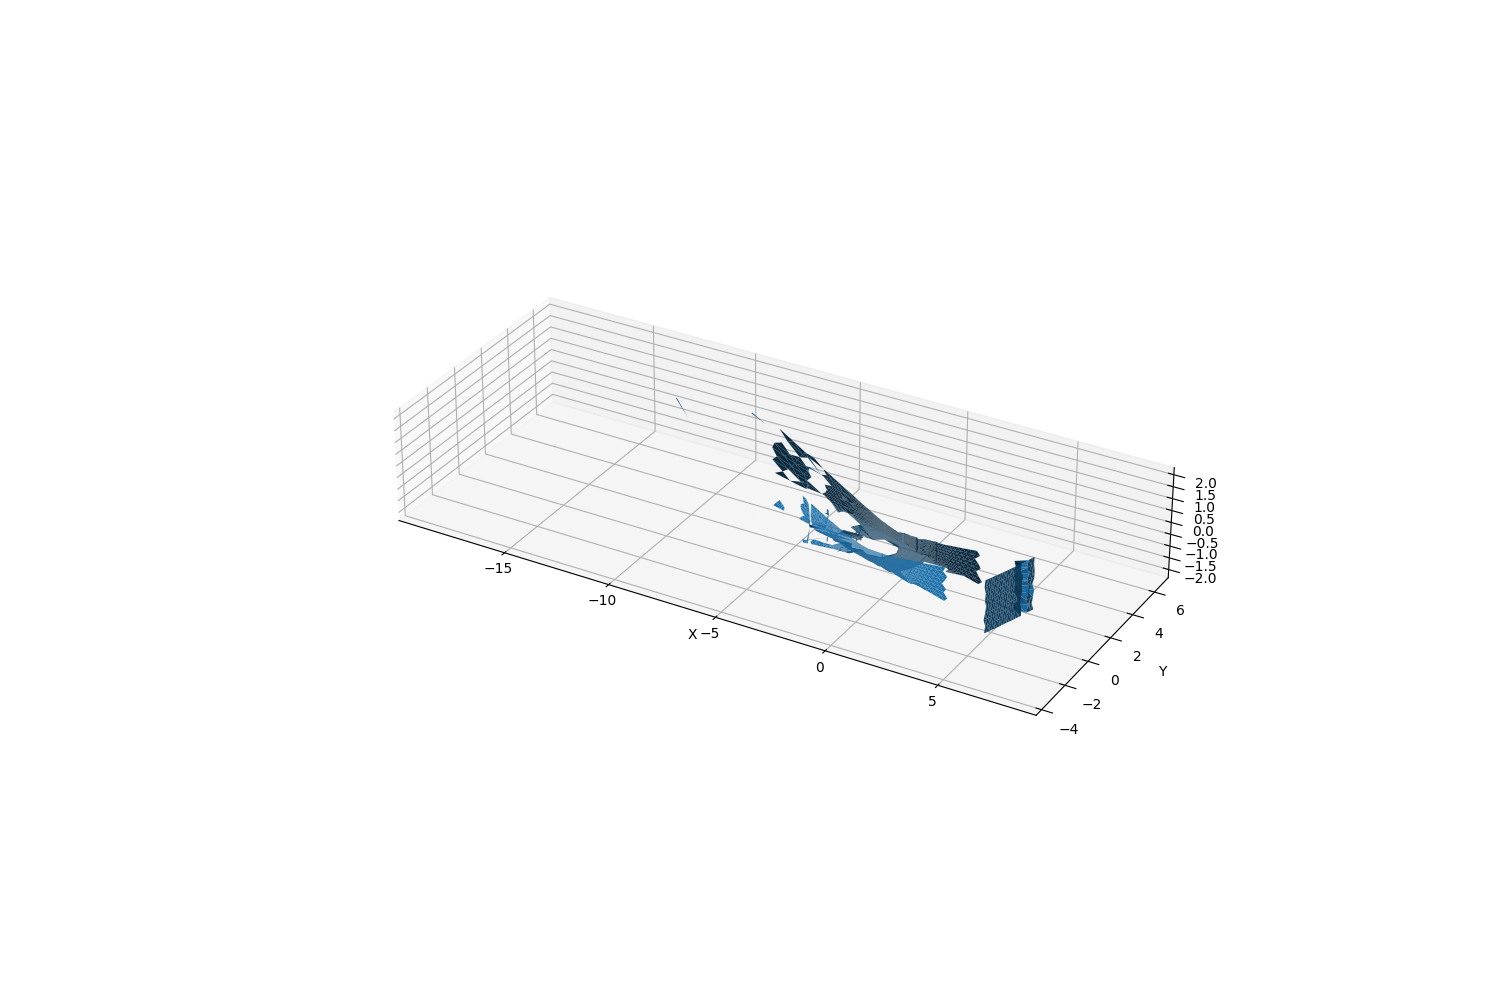

In [7]:
# Plot mesh
ax = plot_3D_setup(PC, figsize=(15,10))
ax.plot_trisurf(PC[:,0], PC[:,1], PC[:,2], triangles=mesh.DT.simplices)

In [ ]:
# Plot clusters
ax = plot_3D_setup(PC)

for i, c in enumerate(clusters):
    cluster_pts = mesh_cluster_pts(mesh, c)
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color='C'+str(i), marker='.', s=3)

Extract planes

In [8]:
planes, vertices, faces = scan_from_clusters(mesh, clusters, avg_normals)
scan = Scan(planes, vertices, faces)

[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[ True False  True False] , is not a valid mask
[False  True False  True] , is not a valid mask
[ True False  True False] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[ True False  True False] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[ True False  True False] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask


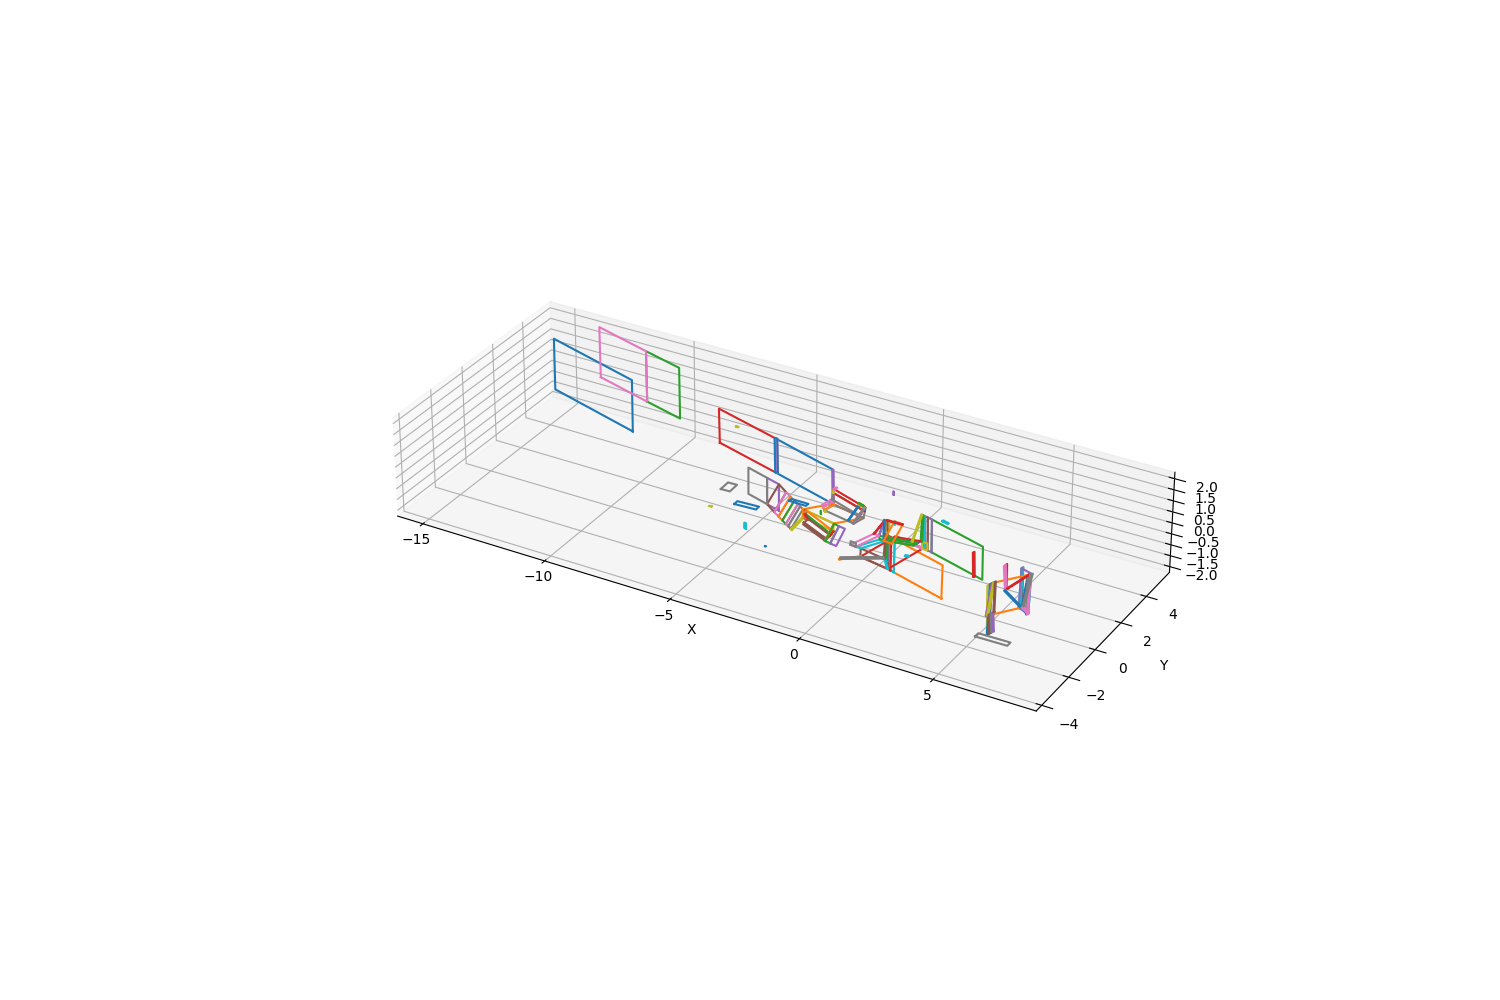

In [9]:
ax = plot_3D_setup(PC)
scan.plot(ax, show_normals=False)

Pclpy

In [9]:
import pclpy
from pclpy import pcl
import math

a = np.random.rand(10,3)
pc = pcl.PointCloud.PointXYZ.from_array(PC)
pc.xyz

array([[-0.2639575 ,  0.66634053, -0.19204374],
       [-0.41531494,  1.050572  ,  0.09883461],
       [-0.4165906 ,  1.0564945 , -0.09935755],
       ...,
       [-0.27041036,  0.7704458 , -0.188509  ],
       [-0.34970236,  0.9985926 ,  0.12991273],
       [-0.35443828,  1.0143858 , -0.0563135 ]], dtype=float32)

In [16]:
rg = pcl.segmentation.RegionGrowing.PointXYZ_Normal()

rg.setInputCloud(pc)
normals_estimation = pcl.features.NormalEstimationOMP.PointXYZ_Normal()
normals_estimation.setInputCloud(pc)
normals = pcl.PointCloud.Normal()
normals_estimation.setRadiusSearch(0.5)
start_time = time.time()
normals_estimation.compute(normals)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.015003204345703125


In [17]:
rg.setInputNormals(normals)
rg.setMaxClusterSize(1000000)
rg.setMinClusterSize(10)
rg.setNumberOfNeighbours(30)
rg.setSmoothnessThreshold(5 / 180 * math.pi)
rg.setCurvatureThreshold(5)
rg.setResidualThreshold(1)
start_time = time.time()
clusters = pcl.vectors.PointIndices()
rg.extract(clusters)
print("Elapsed time: ", time.time() - start_time)
print("Number of clusters: ", len(clusters))

Elapsed time:  0.01557612419128418
Number of clusters:  11


Text(0.5, 0.5, 'Y')

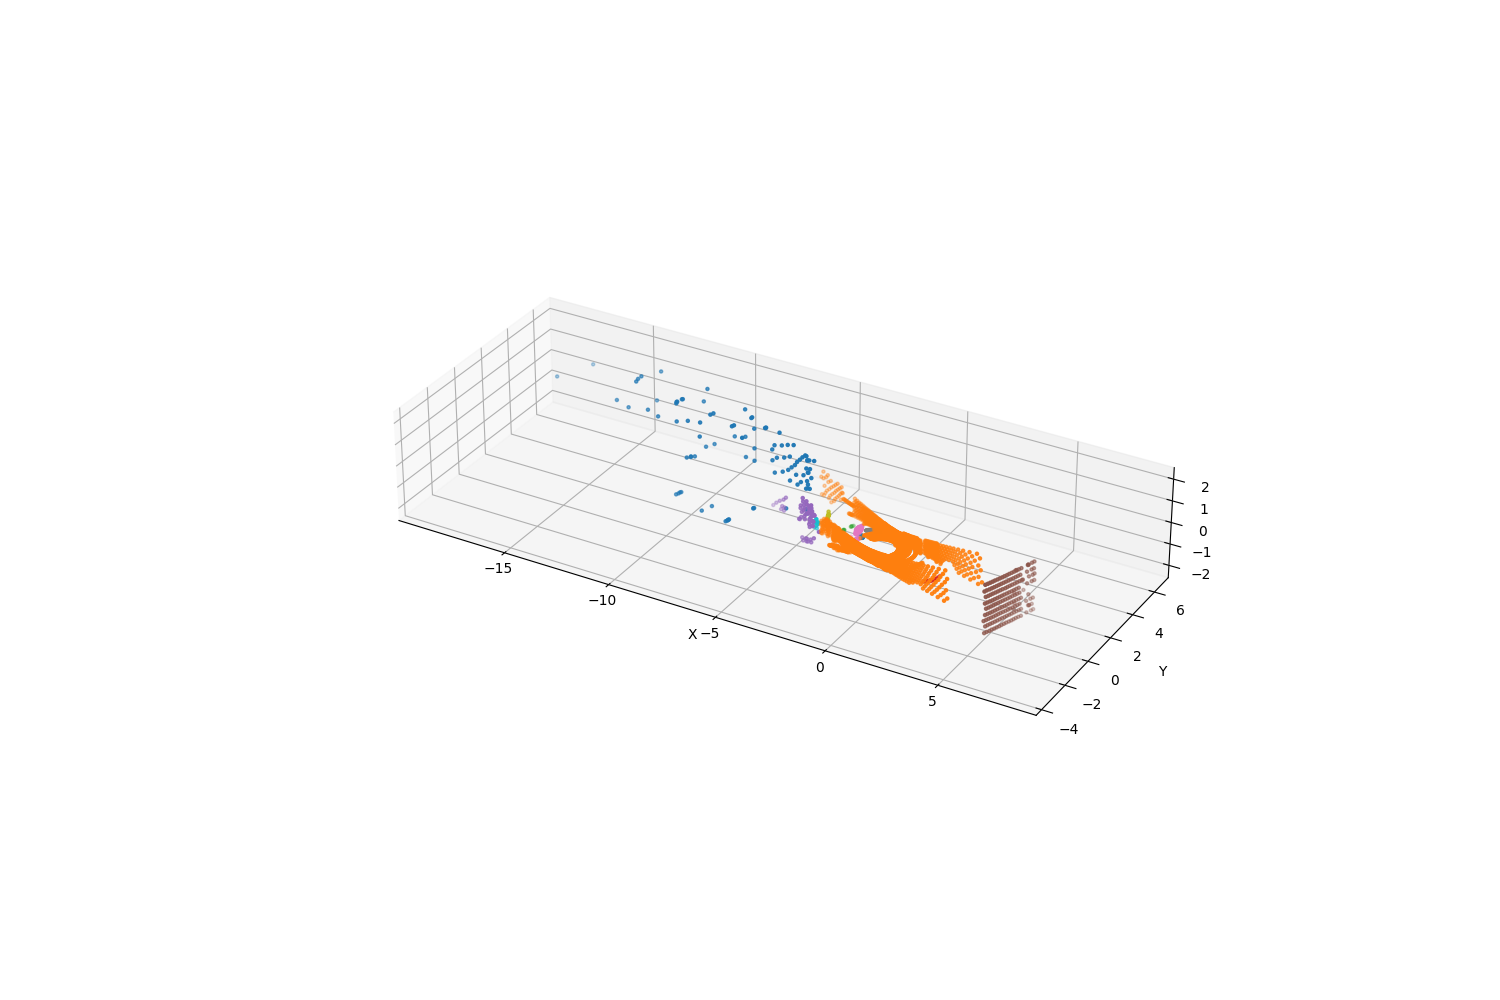

In [18]:
ax = plot_3D_setup(PC)

for i, c in enumerate(clusters):
    idx = c.indices
    ax.scatter3D(pc.xyz[idx,0], pc.xyz[idx,1], pc.xyz[idx,2], color='C'+str(i), marker='.')  
ax.set_box_aspect((np.ptp(pc.xyz[:,0]), np.ptp(pc.xyz[:,1]), np.ptp(pc.xyz[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")